# **CityScapes Depth**

In this notebook, we will learn how to convert stereo image pairs from the cityscapes dataset into high quality depth maps, using CreStereo. 

The resulting depth maps can then be used to train a model to perform monocular depth estimation, where the CreStereo model is acting as a teacher network that can distill knowledge into the student network.

In [1]:
import os
from glob import glob
import sys

import cv2
import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


# local imports
sys.path.append(os.path.dirname(os.getcwd()))

# # One level up
# sys.path.append(os.path.dirname(os.getcwd()))

# Two levels up
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from nets import Model

### Configs

In [28]:
device = 'cuda'
root = "/home/rmajumd/2024/ML_in_image_synthesis/Cityscapes/Cityscapes/cityscapes_dataset"
model_path = "../models/crestereo_eth3d.pth"
OG_W, OG_H = 2048, 1024   # OG width adn height
W1, H1 = OG_W, OG_H # resize w,h for dataloader
W2, H2 = W1//2, H1//2     # resize w,h for model inference

batch_size = 1
n_iter=20


baseline = 0.209313 # meters
f = 2262.52 # x focal length (pixels)

## CityScapes data

We have stored the cityscapes data in the following structure

- cityscapes
    - rightImg8bit
        - train
        - val
        - test
    - leftImg8bit
        - train
        - val
        - test

We will create a simple dataloader to load and preprocess the images so that the disparity can be computed

In [29]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CityScapesStereo(Dataset):
    def __init__(self, root, transform=None, split='train', return_paths=False):
        self.root = root
        self.transform = transform
        self.return_paths = return_paths

        self.left_paths = glob(os.path.join(root, 'leftImg8bit', split, '**/*.png'))
        self.right_paths = glob(os.path.join(root, 'rightImg8bit', split, '**/*.png'))


    def __getitem__(self, idx):
        left = cv2.cvtColor(cv2.imread(self.left_paths[idx]), cv2.COLOR_BGR2RGB)
        right = cv2.cvtColor(cv2.imread(self.right_paths[idx]), cv2.COLOR_BGR2RGB)

        if self.transform:
            left = self.transform(left)
            right = self.transform(right)

        if self.return_paths:
            return left, right, self.left_paths[idx], self.right_paths[idx]

        return left, right
    
    def __len__(self):
        return len(self.left_paths)
    

# helper to convert from pytorch to numpy for display
def convert_to_numpy(image):
    print(f"Number of RGB images: {len(self.left_paths)}")
    print(f"Number of RGB images: {len(self.right_paths)}")
    return image.detach().cpu().numpy().transpose(1, 2, 0)

In [30]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((H1, W1)),
])

In [31]:
model = Model(max_disp=256, mixed_precision=False, test_mode=True)
model.load_state_dict(torch.load(model_path), strict=True)
model.to(device)
model.eval();

/local_scratch/slurm.1297740/ipykernel_2671450/3071419348.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict=True)


Make some optimizations for inference (seems to give a good speedup)
ref: https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html

In [32]:
# zero out all gradients
for param in model.parameters():
    param.grad = None

# find optimal backend for performning convolutions
torch.backends.cudnn.benchmark = True

## Test inference on a sample image

In [33]:
def inference(left, right, model, n_iter=20):

	imgL = left.transpose(2, 0, 1)
	imgR = right.transpose(2, 0, 1)
	imgL = np.ascontiguousarray(imgL[None, :, :, :])
	imgR = np.ascontiguousarray(imgR[None, :, :, :])

	imgL = torch.tensor(imgL.astype("float32"), device='cuda')
	imgR = torch.tensor(imgR.astype("float32"), device='cuda')

	imgL_dw2 = F.interpolate(
		imgL,
		size=(imgL.shape[2] // 2, imgL.shape[3] // 2),
		mode="bilinear",
		align_corners=True,
	)
	imgR_dw2 = F.interpolate(
		imgR,
		size=(imgL.shape[2] // 2, imgL.shape[3] // 2),
		mode="bilinear",
		align_corners=True,
	)
	# print(imgR_dw2.shape)
	with torch.inference_mode():
		pred_flow_dw2 = model(imgL_dw2, imgR_dw2, iters=n_iter, flow_init=None)
		del imgL_dw2, imgR_dw2
		pred_flow = model(imgL, imgR, iters=n_iter, flow_init=pred_flow_dw2)
	pred_disp = torch.squeeze(pred_flow[:, 0, :, :]).cpu().detach().numpy()

	return pred_disp

In [14]:
train_dataset = CityScapesStereo(root, None, 'train')
print("Dataset length:", len(train_dataset))
left, right = train_dataset[19]

Dataset length: 2975


In [15]:
pred_disp = inference(left, right, model, n_iter=20)

/home/rmajumd/2024/ML_in_image_synthesis/Cityscapes/Cityscapes/CREStereo-Pytorch-main/nets/crestereo.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/home/rmajumd/2024/ML_in_image_synthesis/Cityscapes/Cityscapes/CREStereo-Pytorch-main/nets/crestereo.py:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/home/rmajumd/2024/ML_in_image_synthesis/Cityscapes/Cityscapes/CREStereo-Pytorch-main/nets/crestereo.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/home/rmajumd/2024/ML_in_image_synthesis/Cityscapes/Cityscapes/CREStereo-Pytorch-main/nets/crestereo.py:215: FutureWarning: `torch.cuda.amp.autocast(args...)` is de

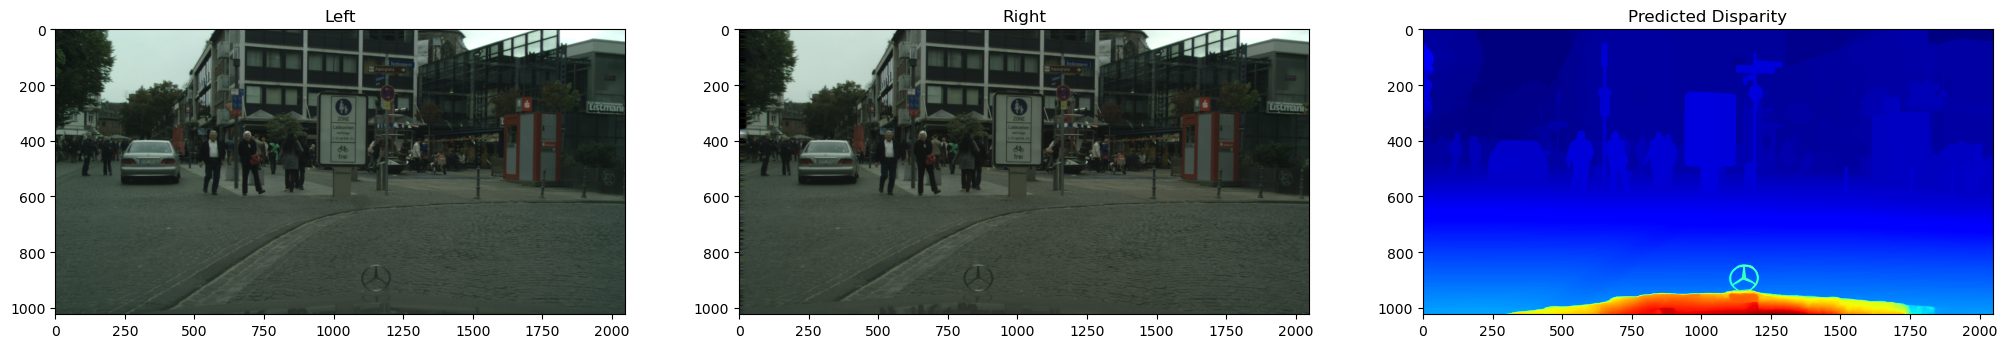

In [17]:
_, ax = plt.subplots(1, 3, figsize=(25, 15))
ax[0].imshow(left)
ax[0].set_title("Left")
ax[1].imshow(right, cmap='jet')
ax[1].set_title("Right")
ax[2].imshow(pred_disp, cmap='jet')
ax[2].set_title("Predicted Disparity");

In [34]:
data_loader = DataLoader(CityScapesStereo(root, transform, 'train', True), batch_size, pin_memory=True)

In [38]:
# data_loader = DataLoader(CityScapesStereo(root, transform, split, True), batch_size, pin_memory=True)

# dataset = data_loader.dataset  # Access the dataset directly
# left, right, left_path, _ = dataset[18]  # Get the 19th element

# # left, right, left_path, _ = data_loader[18]
# pred_disparity = inference(left, right,model)
# pred_depth = baseline * f / (pred_disparity + 0.1)

# _, ax = plt.subplots(1, 3, figsize=(25, 15))
# ax[0].imshow(left)
# ax[0].set_title("Left")
# ax[1].imshow(pred_disp, cmap='jet')
# ax[1].set_title("Predicted Disparity")
# ax[2].imshow(pred_depth)
# ax[2].set_title("Depth Calculated");

## Make a pipeline to predict displarity for all images

In [39]:
def get_disparity(left, right):

	# place resize and place on device
	left_dw2 = F.interpolate(
		left,
		size=(H2, W2),
		mode="bilinear",
		align_corners=True,
	).to(device)

	right_dw2 = F.interpolate(
		right,
		size=(H2, W2),
		mode="bilinear",
		align_corners=True,
	).to(device)
	
	# perform inference
	with torch.inference_mode():
		pred_flow_dw2 = model(left_dw2, right_dw2, iters=n_iter, flow_init=None)
		del left_dw2, right_dw2
		pred_flow = model(left.to(device), right.to(device), iters=n_iter, flow_init=pred_flow_dw2)

	
	return torch.squeeze(pred_flow[:, 0, :, :]).cpu().detach().numpy()

In [40]:
def make_dir(dirpath):
    try:
        os.mkdir(dirpath)
    except:
        try:
            os.mkdir(os.path.split(dirpath)[0])
        except:
            os.mkdir(os.path.split(os.path.split(dirpath)[0])[0])

Create new directories for dat

In [43]:
disp_dir = os.path.join(root, 'crestereo_disparity2_test')
depth_dir = os.path.join(root, 'crestereo_depth2_test')

if not os.path.exists(disp_dir): os.mkdir(disp_dir)
if not os.path.exists(depth_dir): os.mkdir(depth_dir)

In [30]:
for split in ['val']: # ['train', 'val']: # ('train', 'val', 'test'):
    # create split directories
    disp_split_dir = os.path.join(disp_dir, split)
    depth_split_dir = os.path.join(depth_dir, split)

    if not os.path.exists(disp_split_dir): os.mkdir(disp_split_dir)
    if not os.path.exists(depth_split_dir): os.mkdir(depth_split_dir)

    # get dataloader
    data_loader = DataLoader(CityScapesStereo(root, transform, split, True), batch_size, pin_memory=True)
    
    # get depth and disparity for all image pairs
    for i, (left, right, left_path, _) in enumerate(data_loader):

        disp_savepath = left_path[0].replace('leftImg8bit', 'crestereo_disparity2').replace('.png','.npy')
        depth_savepath = left_path[0].replace('leftImg8bit', 'crestereo_depth2').replace('.png','.npy')

        # special case for when the file already exist
        if os.path.exists(disp_savepath) and os.path.exists(depth_savepath):
            continue

        disp_dirname, _= os.path.split(disp_savepath)
        depth_dirname, _= os.path.split(depth_savepath)
        if not os.path.exists(disp_dirname): os.mkdir(disp_dirname)
        if not os.path.exists(depth_dirname): os.mkdir(depth_dirname)
            
        pred_disparity = get_disparity(left, right)
        pred_depth = baseline * f / (pred_disparity + 0.1)

        # cv2.imwrite(disp_savepath, pred_disparity)
        # cv2.imwrite(depth_savepath, pred_depth)
        
        np.save(disp_savepath, pred_disparity)
        np.save(depth_savepath, pred_depth)

In [30]:
for split in ['test']: # ['train', 'val']: # ('train', 'val', 'test'):
    # create split directories
    # disp_split_dir = os.path.join(disp_dir, split)
    depth_split_dir = os.path.join(depth_dir, split)

    # if not os.path.exists(disp_split_dir): os.mkdir(disp_split_dir)
    if not os.path.exists(depth_split_dir): os.mkdir(depth_split_dir)

    # get dataloader
    data_loader = DataLoader(CityScapesStereo(root, transform, split, True), batch_size, pin_memory=True)
    
    # get depth and disparity for all image pairs
    for i, (left, right, left_path, _) in enumerate(data_loader):

        # disp_savepath = left_path[0].replace('leftImg8bit', 'crestereo_disparity2').replace('.png','.npy')
        depth_savepath = left_path[0].replace('leftImg8bit', 'crestereo_depth2').replace('.png','.npy')

        # special case for when the file already exist
        # if os.path.exists(disp_savepath) and os.path.exists(depth_savepath):
        #     continue
        if os.path.exists(depth_savepath):
            continue

        # disp_dirname, _= os.path.split(disp_savepath)
        depth_dirname, _= os.path.split(depth_savepath)
        # if not os.path.exists(disp_dirname): os.mkdir(disp_dirname)
        if not os.path.exists(depth_dirname): os.mkdir(depth_dirname)
            
        pred_disparity = get_disparity(left, right)
        pred_depth = baseline * f / (pred_disparity + 0.1)

        # cv2.imwrite(disp_savepath, pred_disparity)
        # cv2.imwrite(depth_savepath, pred_depth)
        
        # np.save(disp_savepath, pred_disparity)
        np.save(depth_savepath, pred_depth)

KeyboardInterrupt: 

In [45]:
for split in ['train']: # ['train', 'val']: # ('train', 'val', 'test'):
    # create split directories
    # disp_split_dir = os.path.join(disp_dir, split)
    depth_split_dir = os.path.join(depth_dir, split)

    # if not os.path.exists(disp_split_dir): os.mkdir(disp_split_dir)
    if not os.path.exists(depth_split_dir): os.mkdir(depth_split_dir)

    # get dataloader
    data_loader = DataLoader(CityScapesStereo(root, transform, split, True), 1, pin_memory=True)
    
    # get depth and disparity for all image pairs
    for i, (left, right, left_path, _) in enumerate(data_loader):
        
        if i ==19:

            # disp_savepath = left_path[0].replace('leftImg8bit', 'crestereo_disparity2').replace('.png','.npy')
            depth_savepath = left_path[0].replace('leftImg8bit', 'crestereo_depth2').replace('.png','.npy')

            # special case for when the file already exist
            # if os.path.exists(disp_savepath) and os.path.exists(depth_savepath):
            #     continue
            if os.path.exists(depth_savepath):
                continue

            # disp_dirname, _= os.path.split(disp_savepath)
            depth_dirname, _= os.path.split(depth_savepath)
            # if not os.path.exists(disp_dirname): os.mkdir(disp_dirname)
            if not os.path.exists(depth_dirname): os.mkdir(depth_dirname)

            pred_disparity = get_disparity(left, right)
            pred_depth = baseline * f / (pred_disparity + 0.1)

            # np.save(disp_savepath, pred_disparity)
            np.save(depth_savepath, pred_depth)
            
            break

        # cv2.imwrite(disp_savepath, pred_disparity)
        # cv2.imwrite(depth_savepath, pred_depth)

IndexError: list index out of range

In [26]:
disp_savepath

'/home/rmajumd/2024/ML_in_image_synthesis/Cityscapes/Cityscapes/cityscapes_dataset/crestereo_disparity/train/zurich/zurich_000121_000019_crestereo_disparity.png'

In [27]:
left_path

['/home/rmajumd/2024/ML_in_image_synthesis/Cityscapes/Cityscapes/cityscapes_dataset/leftImg8bit/train/zurich/zurich_000121_000019_leftImg8bit.png']

In [28]:
data_loader = DataLoader(CityScapesStereo(root, transform, split, True), batch_size, pin_memory=True)